# EDA - Products Data

## Overview
Let's begin with high-level statistics about our product and review data consisting of roughly 8M reviews of 1M books and albums.

In [41]:
%load_ext autoreload
%autoreload 

import sqlite3 as sql
import time

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd

from shared.profile import Profiler
from shared.viz import set_style, barh, plot_rates
from shared.query import query
from shared.format import describe_number

pd.set_option('display.max_colwidth', 200)
set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
conn = sql.connect('data/products.sql')

### Database Schema

In [6]:
print("SQL Schema:")
query("SELECT * FROM sqlite_master ORDER BY tbl_name", conn)

SQL Schema:
SELECT * FROM sqlite_master ORDER BY tbl_name: 10 results in 0.003 seconds


,type,name,tbl_name,rootpage,sql
0,table,product,product,7,"CREATE TABLE product(\n id VARCHAR(36) PRIMARY KEY NOT NULL,\n title TEXT DEFAULT '',\n title_search TEXT DEFAULT '', -- search variation for title\n creator TEXT DEFAULT '', -- = auth..."
1,index,sqlite_autoindex_product_1,product,8,None
2,index,product_category_id,product,4837,"CREATE INDEX product_category_id ON product(category, id)"
3,index,product_title_search,product,1330236,CREATE INDEX product_title_search ON product(title_search)
4,index,product_creator_search,product,1279504,CREATE INDEX product_creator_search ON product(creator_search)
5,table,review,review,2,"CREATE TABLE review(\n user_id VARCHAR(36),\n product_id VARCHAR(36) NOT NULL,\n\n title TEXT DEFAULT '',\n review TEXT DEFAULT '',\n\n rating DECIMAL(2,1) NOT NULL,\n upvotes IN..."
6,index,review_product_id,review,910296,CREATE INDEX review_product_id ON review(product_id)
7,index,review_user_id_product_id_review,review,199,"CREATE INDEX review_user_id_product_id_review ON review(user_id, product_id, rating, upvotes, downvotes)"
8,table,sqlite_stat1,sqlite_stat1,3145,"CREATE TABLE sqlite_stat1(tbl,idx,stat)"
9,table,sqlite_stat4,sqlite_stat4,3220,"CREATE TABLE sqlite_stat4(tbl,idx,neq,nlt,ndlt,sample)"


### Products and Reviews by Category

In [7]:
p = Profiler()

review_counts = query(f"""
SELECT category, COUNT(*) as reviews
FROM review r
JOIN product p ON r.product_id = p.id
GROUP BY category 
""", conn).set_index('category');
p.log("Got user reviews by category")

product_counts = query(f"""
SELECT category, COUNT(*) AS products
FROM product 
GROUP BY category 
""", conn).set_index('category');
p.log("Got products by category")

creator_counts = query(f"""
SELECT category, COUNT(DISTINCT(creator)) AS creators
FROM product 
GROUP BY category 
""", conn).set_index('category');
p.log("Got artists/authors by category")

# Obtaining user counts times out quite badly. Replacing user_id with product_id does not.
#user_counts = query(f"""
#    SELECT category, COUNT(DISTINCT(user_id)) AS users
#    FROM review r
#    JOIN product p ON r.product_id = p.id
#    GROUP BY category 
#""");
#p.log("Got users by category")

summary = pd.concat([review_counts, product_counts, creator_counts], axis = 1)

summary.map(describe_number)


SELECT category, COUNT(*) as reviews
FROM review r
JOIN product p ON r.product_id = p.id
GROUP BY category 
: 2 results in 4.573 seconds
4.573:	Got user reviews by category

SELECT category, COUNT(*) AS products
FROM product 
GROUP BY category 
: 2 results in 0.117 seconds
4.691:	Got products by category

SELECT category, COUNT(DISTINCT(creator)) AS creators
FROM product 
GROUP BY category 
: 2 results in 13.033 seconds
17.724:	Got artists/authors by category


,reviews,products,creators
category,,,
Books,2.6M,212.4K,127.3K
Music,4.8M,768.2K,228.4K


## User Reviews Per Product

### Most Reviewed Books / Authors / Albums / Artists

In [8]:
category = 'Books'

def most_reviewed_query(category: str, columns, limit = None) -> pd.DataFrame:
    columns = columns if isinstance(columns, str) else ','.join(columns)
    result = f"""
    SELECT p.{columns}, COUNT(*) AS reviews, p.category, p.subcategory
    FROM review r JOIN product p ON r.product_id = p.id
    WHERE category = '{category}'
    GROUP BY p.{columns} ORDER BY reviews DESC
    """
    if limit != None:
        result += f' LIMIT {limit}'
    return result

def most_reviewed(category: str, column: str, limit = None) -> pd.DataFrame:
    return query(most_reviewed_query(category, column, limit), conn)

In [9]:
book_reviews = most_reviewed('Books', 'title')
book_reviews[:10]


    SELECT p.title, COUNT(*) AS reviews, p.category, p.subcategory
    FROM review r JOIN product p ON r.product_id = p.id
    WHERE category = 'Books'
    GROUP BY p.title ORDER BY reviews DESC
    : 212397 results in 3.024 seconds


,title,reviews,category,subcategory
0,Harry Potter and The Sorcerer's Stone,6711,Books,Juvenile Fiction
1,The Hobbit There and Back Again,4331,Books,Adventure stories
2,"The Hobbitt, or there and back again; illustrated by the author.",4316,Books,Fiction
3,The Hobbit or There and Back Again,4266,Books,Juvenile Fiction
4,"The Hobbit; Or, There and Back Again",4166,Books,nan
5,The Hobbit,4118,Books,Juvenile Fiction
6,The Giver,3770,Books,Juvenile Fiction
7,Holes,3512,Books,Juvenile Fiction
8,The Catcher in the Rye,3208,Books,nan
9,The Catcher in the Rye [Audiobook] [Cd] [Unabridged] (Audio CD),3199,Books,Young Adult Fiction


In [10]:
author_reviews = most_reviewed('Books', 'creator').rename(columns = {'creator': 'author'})
author_reviews[:10]


    SELECT p.creator, COUNT(*) AS reviews, p.category, p.subcategory
    FROM review r JOIN product p ON r.product_id = p.id
    WHERE category = 'Books'
    GROUP BY p.creator ORDER BY reviews DESC
    : 127273 results in 2.200 seconds


,author,reviews,category,subcategory
0,nan,346121,Books,nan
1,J. R. R. Tolkien,18877,Books,Fiction
2,Charles Dickens,13905,Books,nan
3,John Steinbeck,11808,Books,Fiction
4,John Ronald Reuel Tolkien,11170,Books,"Fantasy literature, English"
5,J. K. Rowling,9852,Books,Juvenile Fiction
6,Jane Austen,9814,Books,England
7,Harper Lee,9392,Books,Study Aids
8,Stephen King,8869,Books,Fiction
9,George Orwell,8124,Books,Fiction


In [11]:
artist_reviews = most_reviewed('Music', 'creator').rename(columns = {'creator': 'artist'})
artist_reviews[:10]


    SELECT p.creator, COUNT(*) AS reviews, p.category, p.subcategory
    FROM review r JOIN product p ON r.product_id = p.id
    WHERE category = 'Music'
    GROUP BY p.creator ORDER BY reviews DESC
    : 228367 results in 10.324 seconds


,artist,reviews,category,subcategory
0,Various Artists,108639,Music,
1,,41374,Music,
2,VARIOUS ARTISTS,32207,Music,
3,Various,29545,Music,
4,The Beatles,25296,Music,
5,Rated: Unrated,24376,Music,
6,Elvis Presley,16448,Music,
7,Pink Floyd,15473,Music,
8,The Rolling Stones,12656,Music,
9,Bob Dylan,12497,Music,


In [12]:
album_reviews = most_reviewed('Music', ['title', 'creator']).rename(columns = {'creator': 'artist'})
album_reviews[:10]


    SELECT p.title,creator, COUNT(*) AS reviews, p.category, p.subcategory
    FROM review r JOIN product p ON r.product_id = p.id
    WHERE category = 'Music'
    GROUP BY p.title,creator ORDER BY reviews DESC
    : 692618 results in 12.901 seconds


,title,artist,reviews,category,subcategory
0,25,Adele,5097,Music,
1,That's Christmas To Me,Pentatonix,3629,Music,
2,Traveller,Chris Stapleton,3211,Music,
3,Hamilton O.B.C.R. Explicit Lyrics,Lin-Manuel Miranda,3073,Music,
4,Oscd Ad Adele 21,Adele,2932,Music,
5,Partners,Barbra Streisand,2928,Music,
6,1989,Taylor Swift,2421,Music,
7,Fallen,Evanescence,2119,Music,
8,I Dreamed A Dream,Susan Boyle,2083,Music,
9,Thriller,Michael Jackson,1988,Music,


### Breakdown by Review Count
Recommender systems depend on having reasonable numbers of user reviews. To find out how many of our books, authors, albums, etc have enough reviews to make reasonable recommendations, let's establish visual for percentage of products that have x or more reviews:

In [13]:

def values_by_review_count(values, review_counts) -> pd.DataFrame:
    """
    Given a series of objects and their review counts, returns a histogram of review counts.

    In other words, converts a dataset of review counts per product to a dataset of products per review count.
    """
    assert(len(values) == len(review_counts))
    max_reviews = review_counts.max()
    buckets = range(0, max_reviews + 1)
    products_per_review_count = np.histogram(review_counts, bins = buckets)
    return pd.DataFrame(products_per_review_count, index = ['count', 'reviews']).T.set_index('reviews')

In [14]:
books_by_review_count = values_by_review_count(book_reviews.title, book_reviews.reviews)
authors_by_review_count = values_by_review_count(author_reviews.author, author_reviews.reviews)
albums_by_review_count = values_by_review_count(album_reviews.title, album_reviews.reviews)
artists_by_review_count = values_by_review_count(artist_reviews.artist, artist_reviews.reviews)

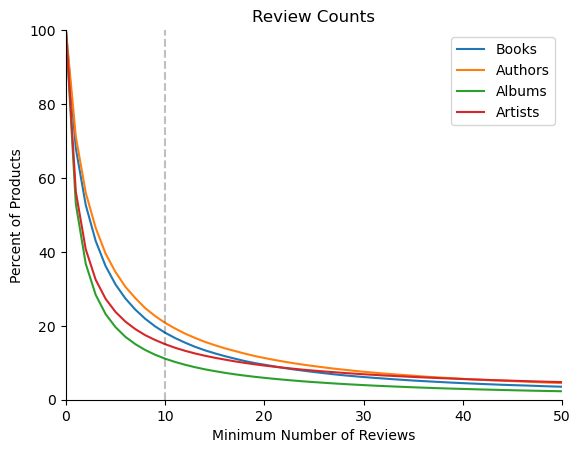

In [15]:
plots = [
    ('Books', books_by_review_count),
    ('Authors', authors_by_review_count),
    ('Albums', albums_by_review_count),
    ('Artists', artists_by_review_count)
]
def counts_to_percentages(counts: pd.Series) -> pd.Series:
    return 100 * counts.cumsum() / counts.sum()

for title, data in plots:
    # normalize counts into percentages
    x = data.index
    y = 100 - counts_to_percentages(data['count'])
    plt.plot(x, y, label = title)


#plt.plot(product_percentage_by_review_count)
plt.gca().set(
    xlim = (0, 50),
    ylim = (0, 100),
    xlabel = 'Minimum Number of Reviews',
    ylabel = 'Percent of Products',
    title = f'Review Counts'
)
plt.legend()
plt.axvline(10, linestyle = '--', color = 'k', alpha = 0.25)
plt.grid(False)

### Observations



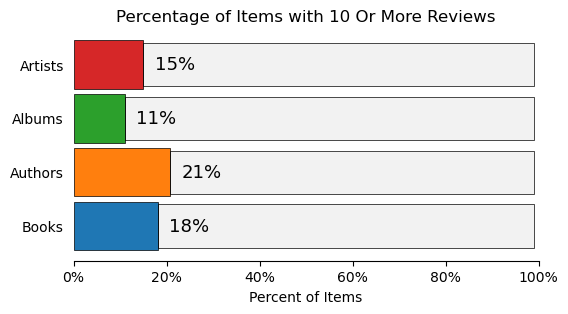

In [49]:
def plot_review_cutoff(cutoff: int):
    ys = [tuple[0] for tuple in plots]
    widths = [tuple[1] for tuple in plots]
    widths = [counts_by_review['count'].cumsum().iloc[cutoff] / counts_by_review['count'].sum() for counts_by_review in widths]
    widths = [1 - x for x in widths]
    plot_rates(ys, widths, colors = ['C0', 'C1', 'C2', 'C3'])
    ax = plt.gca()
    ax.set(
        xlabel = 'Percent of Items',
        title = f'Percentage of Items with {cutoff} Or More Reviews'
    )

plt.figure(figsize = (6,3))
plot_review_cutoff(10)

### Close Connection

In [17]:
conn.close()